In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pickle

sns.set()

In [2]:
# training parameters
BATCH_SIZE = 200
EPOCHS = 100

In [3]:
# data from: https://github.com/ayushgarg31/HNN-Neurips2019
with open('pendulum-pixels-dataset.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
def pixelhnn_loss(x, x_next, model, epoch):
    # transforming to latent space
    # image -> latent space
    latent = model.encode(x)
    latent_next = model.encode(x_next)


    # autoencoder loss
    x_dot = model.decode(latent)
    autoencoder_loss = ((x - x_dot)**2).mean(1)

    # hnn loss
    latent_dot_next = latent + model.model_diff(latent) # ez baseline-nál nem jó
    hnn_loss = ((latent_next - latent_dot_next)**2).mean(1)

    # canonical coordinates loss
    # latent vector -> (x, v)
    latent_q, latent_p = latent.split(1,1)
    latent_q_next, Latent_p_next = latent_next.split(1,1)
    latent_loss = ((latent_p - (latent_q - latent_q_next))**2).mean(-1)

    loss = autoencoder_loss + 0.1 * hnn_loss + 0.1 * latent_loss

    if epoch < 25:
        loss = autoencoder_loss
    elif 25 <= epoch < 35:
        loss = autoencoder_loss + 0.1 * latent_loss
    elif 35 <= epoch < 45:
        loss = autoencoder_loss + 0.5 * latent_loss
    elif 45 <= epoch < 55:
        loss = autoencoder_loss + 1 * latent_loss
    elif 55 <= epoch < 65:
        loss = autoencoder_loss + latent_loss + 0.1 * hnn_loss
    elif 65 <= epoch < 75:
        loss = autoencoder_loss + latent_loss + 0.1 * hnn_loss
    else:
        loss = autoencoder_loss + latent_loss + hnn_loss
    

    return loss.mean()

In [5]:
from models import MLP_autoencoder, PixelHNN


baseline = MLP_autoencoder(dims=56*28)
model = PixelHNN(dims=56*28)

In [6]:
# test, train data
pixels = torch.Tensor(data['pixels'])
next_pixels = torch.Tensor(data['next_pixels'])
test_pixels = torch.Tensor(data['test_pixels'])
test_next_pixels = torch.Tensor(data['test_next_pixels'])

coords = data['coords']

In [7]:
import torch.optim as optim

optimizer1 = optim.Adam(baseline.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer2 = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
%%time

log = {'train_loss': [], 'test_loss': []}
for step in range(EPOCHS * BATCH_SIZE):

    ixs = torch.randperm(pixels.shape[0])[:BATCH_SIZE]
    loss = pixelhnn_loss(pixels[ixs], next_pixels[ixs], model, step / BATCH_SIZE)

    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    if ((step + 1) / BATCH_SIZE) % 10 == 0:

        log['train_loss'].append(loss.item())

        #  validation
        test_ixs = torch.randperm(test_pixels.shape[0])[:BATCH_SIZE]
        test_loss = pixelhnn_loss(test_pixels[test_ixs], test_next_pixels[test_ixs], model, step / BATCH_SIZE)
        log['test_loss'].append(test_loss.item())

        print("Epoch {:.0f} | Train loss {:.5f} | Test loss {:.5f}".format((step + 1) / BATCH_SIZE, loss.item(), test_loss.item()))
            
print('-----------------------------')
print('Finished Training')

Epoch 10 | Train loss 0.02182 | Test loss 0.02182
Epoch 20 | Train loss 0.02186 | Test loss 0.02183
Epoch 30 | Train loss 0.02233 | Test loss 0.02234
Epoch 40 | Train loss 0.02446 | Test loss 0.02437
Epoch 50 | Train loss 0.02683 | Test loss 0.02714
Epoch 60 | Train loss 0.03060 | Test loss 0.03098
Epoch 70 | Train loss 0.03090 | Test loss 0.03051
Epoch 80 | Train loss 0.06469 | Test loss 0.06429
Epoch 90 | Train loss 0.06429 | Test loss 0.06405
Epoch 100 | Train loss 0.06399 | Test loss 0.06430
-----------------------------
Finished Training
Wall time: 6min 1s


In [9]:
latents = model.encode(pixels).detach().numpy()

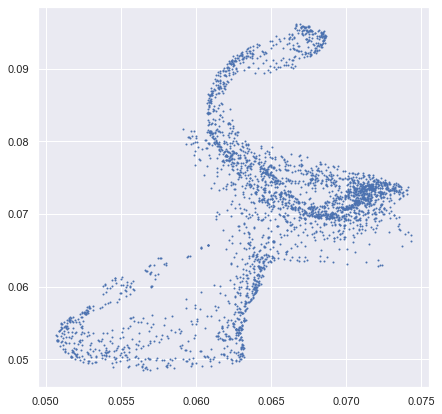

In [10]:
n = 3000

plt.figure(figsize=(7,7))
plt.plot(latents[:n,0], latents[:n,1], '.', markersize=2)

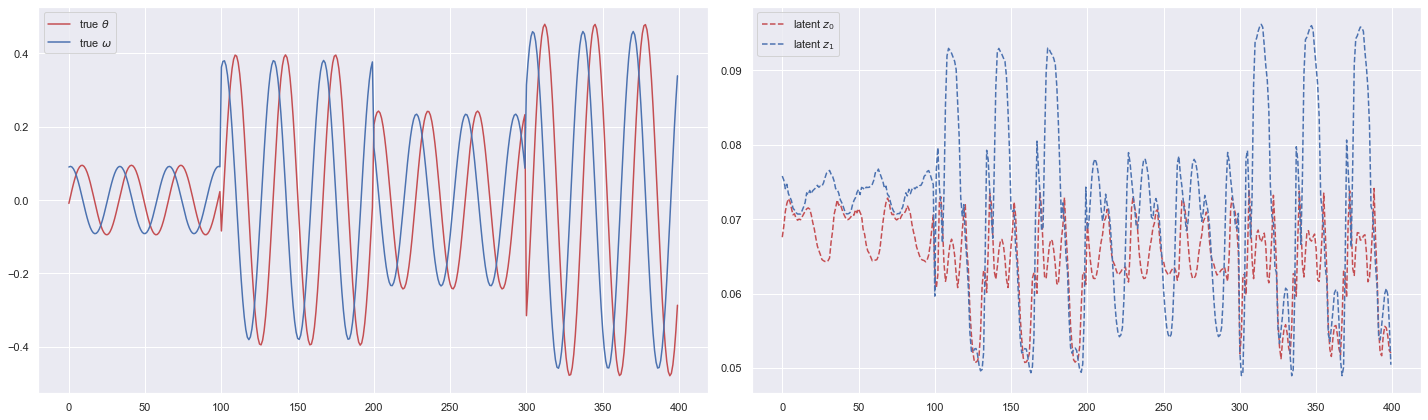

In [11]:
k = 400
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(coords[:k,0], "r-", label='true $\\theta$')
plt.plot(coords[:k,1], "b-", label='true $\omega$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(latents[:k,0], "r--", label='latent $z_0$')
plt.plot(latents[:k,1], "b--", label='latent $z_1$')
plt.legend()

plt.tight_layout() ; plt.show()